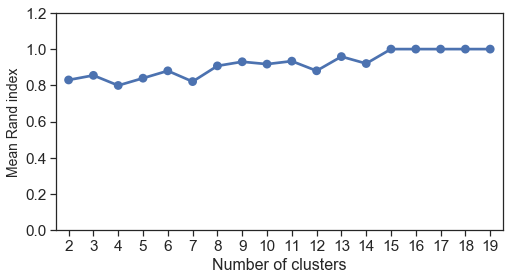

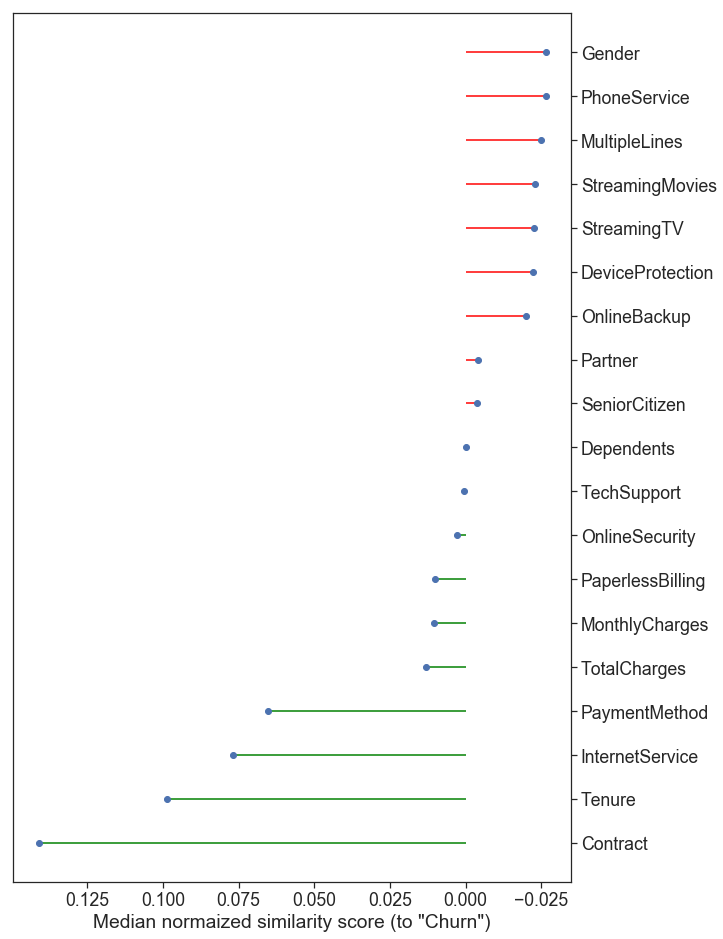

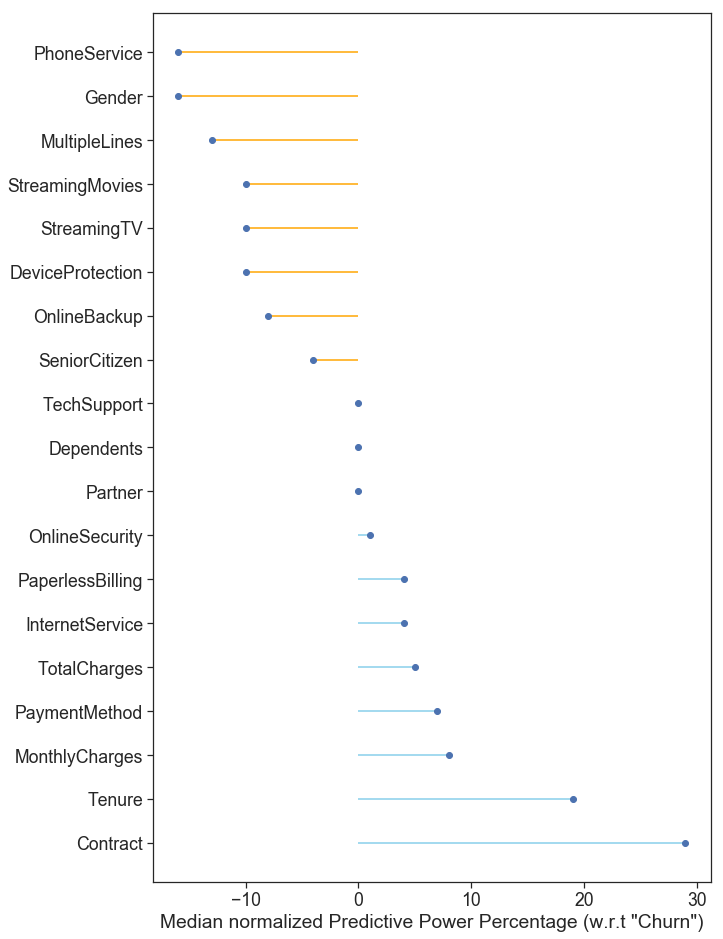

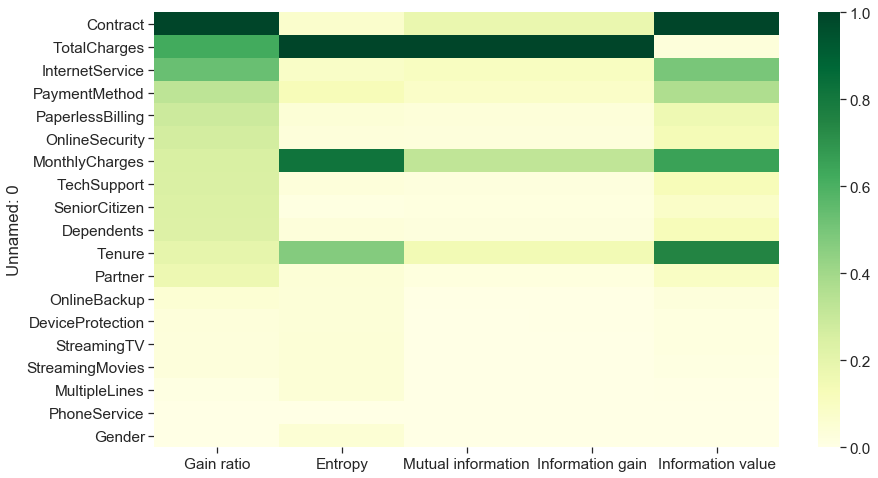

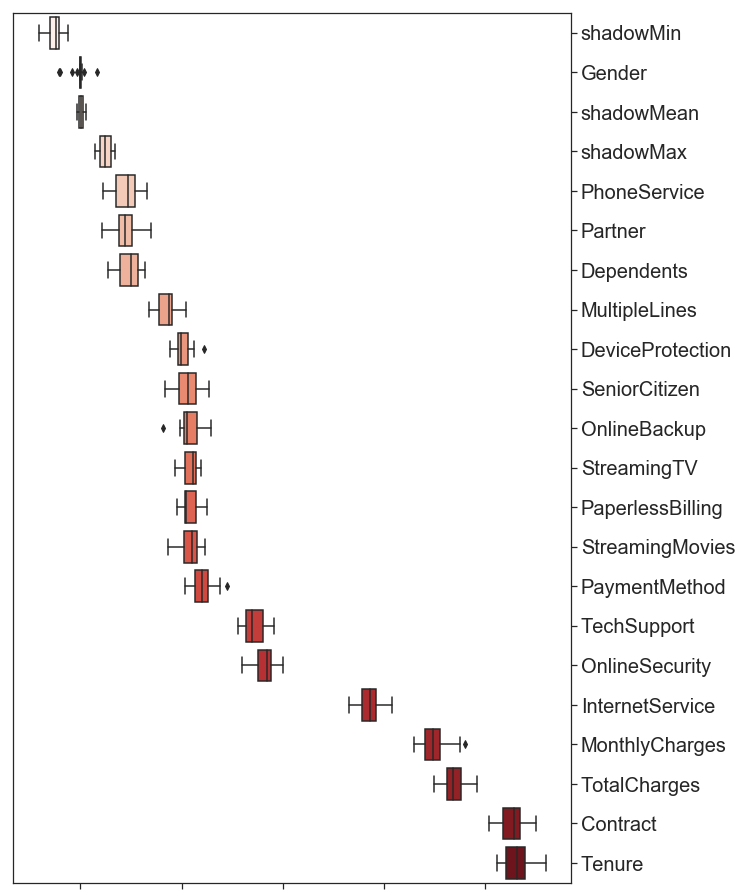

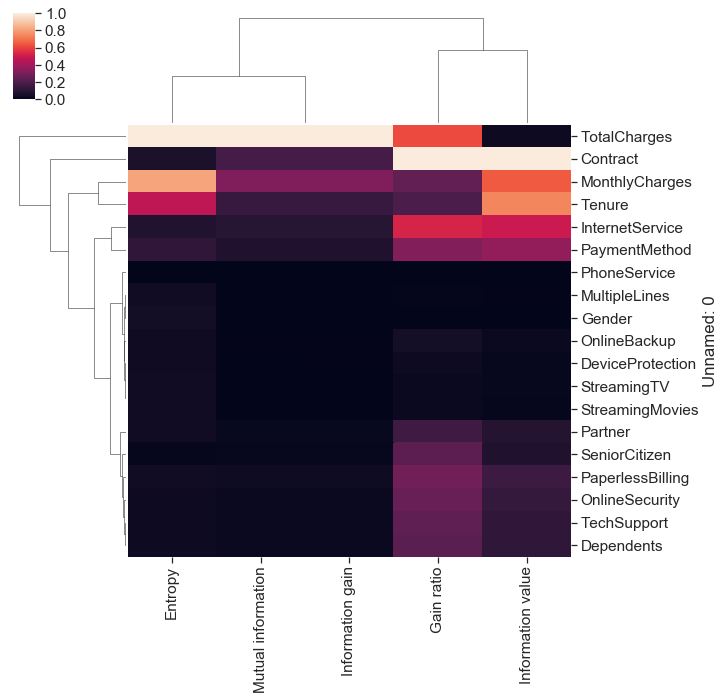

AppLayout(children=(HTML(value='\n<a href="www.google.com">Come to my site!</a>\n\n\n', layout=Layout(grid_are…

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, HTML, HBox, VBox, Layout, AppLayout, Output
#from ipywidgets import HTML, Layout, Dropdown, Output, Textarea, VBox, Label
import numpy as np
import seaborn as sns
import markdown 
from IPython.display import display
import pickle

%matplotlib inline

df = pd.read_csv('https://github.com/nchelaru/data-prep/raw/master/telco_cleaned_yes_no.csv')


''''''


## Tab 1
bg_clustofvar = '''
<p style="font-size:14px">
As the <a href='https://github.com/chavent/ClustOfVar'><code>ClustOfVar</code></a> package allows hierarchical clustering of mixed-type (namely, both categorical and continuous) 
variables, it is the only method introduced here that takes an unsupervised approached to characterizing variable 
"informativeness".

<br><br>

After clustering, the corrected Rand index is calculated for each number of possible partition of the tree, where the number of 
partition with the highest corrected Rand index is the most “stable”. In this example, we can visualize the dendrogram of clustered 
variables cut into <b>six</b> clusters, which is a local peak that gives a manageable number of clusters. 

<br><br>

The clustering results should be complemented with some more data exploration
and domain knowledge, to identify which variable(s) in each cluster are the most important to each cluster, 
so that the rest can be removed (so as to achieve feature selection) before further analyses. 
In addition, this clustering can provide insights into which customer characteristics and/or purchasing behaviour are most related to each other, 
which can be actionable in themselves.
</p>
'''


code_clustofvar = '''
<p style="font-size:14px"><pre>
## Import libraries
library(ClustOfVar)
library(PCAmixdata)
library(dendextend)

## Import data
df <- read.csv("https://github.com/nchelaru/data-prep/raw/master/telco_cleaned_yes_no.csv")

## Split up continuous and categorical varibles
split <- splitmix(df)

X1 <- split$X.quanti 

X2 <- split$X.quali

## Hierarchical clustering
tree <- hclustvar(X.quanti = X1, X.quali = X2)

## Evaluate the stability of each partition
stability(tree, B=60) ## 60 bootstrap samples

## Plot
dend <- tree %>% as.dendrogram %>% hang.dendrogram

dend %>% color_branches(k=6) %>% color_labels(k=6) %>% plot(horiz=TRUE)
</pre></p>
'''

output_line = widgets.Output(layout=Layout(margin='auto'))

with output_line:
    pickleFile = open("stability_res.pickle", 'rb')
    
    k = pickle.load(pickleFile)

    plt.figure(figsize=(8, 4))
    
    sns.pointplot(x = list(range(2, 20)), y=k)
    
    plt.xlabel("Number of clusters", fontsize=16)
    plt.ylabel('Mean Rand index', fontsize=14)
    plt.ylim(0, 1.2)
    
    plt.show()

accordion = widgets.Accordion(children=[widgets.HTML(value=bg_clustofvar),
                                        widgets.HTML(value=code_clustofvar)])

accordion.set_title(0, 'Background')
accordion.set_title(1, 'General workflow')

taba = VBox(children=[output_line])
tabb = VBox(children=[widgets.HTML(value='<img src="./hclust_res.png" height="370px"/>', 
                                  layout=Layout(margin='auto'))])

tab_set = widgets.Tab(children=[taba, tabb])

tab_set.set_title(0, 'Optimal no. clusters')
tab_set.set_title(1, 'Clustered variables')

# tab1 = VBox(children=[HBox(children=[output_line,
#                                      widgets.HTML(value='<img src="./hclust_res.png" height="350px"/>')]),
#                       accordion])

tab1 = VBox(children=[tab_set, accordion])


''''''

## Tab 2

bg_varsim = '''
<p style="font-size:14px">
Finding which variables in a dataset are most “similar”, in some way, to
the outcome variable of interest can be a very useful first step in understanding
the dataset and planning the next steps. 

<br><br>

The <a href='https://github.com/chavent/ClustOfVar'><code>ClustOfVar</code></a> package also has an implementation for this purpose in the <code>mixedVarSim()</code> function. According 
to its <a href='https://www.rdocumentation.org/packages/ClustOfVar/versions/1.1/topics/mixedVarSim'>documentation</a>, the function calculates 1) 
the <b>square of the Pearson correlation</b> when the two variables are quantitative, 2) the <b>correlation ratio</b> when one variable is quantitative 
  and the other one is qualitative, and 3) the <b>square of the canonical correlation</b> between two sets of dummy variables when the two variables are qualitative.

<br><br>

To help interpret the results, the measure for each variable is normalized by subtracting the median value, so variables with positive values 
have variable importance higher than the median and can be considered as "more informative" than those with negative normalized 
values.
</p>
'''


code_varsim = '''
<p style="font-size:14px"><pre>
## Import libraries
library(ClustOfVar)

## Import data
raw_df <- read.csv('https://github.com/nchelaru/data-prep/raw/master/telco_cleaned_renamed.csv')

## Calculate similarity between each variable and Churn
i <- 1

score_list = list()

for (c in colnames(within(raw_df, rm("Churn")))){
  score_list[[i]] <- mixedVarSim(raw_df[[c]], raw_df$Churn)
  
  i <- i + 1
}

## Concatenate the two lists to a dataframe
score_df <- do.call(rbind, 
                    Map(data.frame, 
                        Var=as.list(colnames(within(raw_df, rm("Churn")))), 
                        Score=score_list))
</pre></p>
'''
 


accordion2 = widgets.Accordion(children=[widgets.HTML(value=bg_varsim),
                                        widgets.HTML(value=code_varsim)], 
                              layout=Layout(width='50%', margin='30px'))

accordion2.set_title(0, 'Background')
accordion2.set_title(1, 'General workflow')

output1 = widgets.Output(layout=Layout(margin='40px', width='50%'))

with output1:
    score_df = pd.read_csv('./score_df.csv')
    
    score_df['Norm_Score'] = score_df['Score'] - score_df['Score'].median()
    
    score_df.sort_values(by='Norm_Score', inplace=True, ascending=False)
    
    sns.set(rc={'figure.figsize':(12, 14)}, 
            style='ticks', font_scale=1.6)

    my_range=range(1,len(score_df.index)+1)
    
    my_color=np.where(score_df['Norm_Score']>=0, 'green', 'red')

    plt.hlines(y=my_range, xmin=0, xmax=score_df['Norm_Score'],
               color=my_color)
    
    plt.plot(score_df['Norm_Score'], my_range, "o")

    # Add titles and axis names
    plt.yticks(my_range, score_df['Var'])
    plt.xlabel('Median normaized similarity score (to "Churn")')
    plt.gca().yaxis.set_ticks_position("right")
    plt.gca().invert_xaxis()

    plt.show()
    
tab2 = HBox(children=[accordion2, output1])

''''''

## Tab 3

bg_autoEDA = '''
<p style="font-size:14px">
In addition to making generating exploratory visualizations a breeze, the <a href='https://github.com/XanderHorn/autoEDA'><code>autoEDA</code></a> package 
has an useful <code>predictivePower()</code> function that calculates the “predictive power” of each input 
feature with respect to an outcome feature of your choice, which is quantified by
<b>correlation</b> when the outcome feature is continuous and the <b>Kolmogorov-Smirnov distance</b> when it is categorical.

<br><br>

Note, the author of the package has <b>warned</b> that the estimation of feature 
predictive power is sensitive to how the data is prepared. Therefore, 
like all other tasks in data science, it is very advisable to put the same dataset through
different analysis methods and see how the results match up.

<br><br>

As before, to help interpret the results, the measure for each variable is normalized by subtracting the median value, so variables with positive values 
have variable importance higher than the median and can be considered as "more informative" than those with negative normalized 
values.
</pre>
'''


code_autoEDA = '''
<p style="font-size:14px"><pre>
## Import libraries
library(autoEDA)
library(ggplot2)

## Calculate variable predictive power
autoEDA_imp <- predictivePower(df, y="Churn", outcomeType = "automatic")

## Sort variables by their predictive power
autoEDA_imp[order(-autoEDA_imp$PredictivePowerPercentage), ] 
</pre></p>
'''
 


accordion3 = widgets.Accordion(children=[widgets.HTML(value=bg_autoEDA),
                                        widgets.HTML(value=code_autoEDA)], 
                              layout=Layout(width='50%', margin='30px'))

accordion3.set_title(0, 'Background')
accordion3.set_title(1, 'General workflow')

output2 = widgets.Output(layout=Layout(margin='40px', width='50%'))


with output2:
    
    # libraries
    autoEDA_df = pd.read_csv('autoEDA_df.csv')
    
    autoEDA_df['Norm_PPP'] = autoEDA_df["PredictivePowerPercentage"] - autoEDA_df["PredictivePowerPercentage"].median()
    
    my_color=np.where(autoEDA_df['Norm_PPP']>=0, 'skyblue', 'orange')
    
    sns.set(rc={'figure.figsize':(12, 14)}, 
            style='ticks', font_scale=1.6)

    my_range=range(1,len(autoEDA_df.index)+1)

    # The vertival plot is made using the hline function
    # I load the seaborn library only to benefit the nice looking feature

    plt.hlines(y=my_range, xmin=0, xmax=autoEDA_df['Norm_PPP'],
               color=my_color)
    
    plt.plot(autoEDA_df['Norm_PPP'], my_range, "o")

    # Add titles and axis names
    plt.yticks(my_range, autoEDA_df['Feature'])
    plt.xlabel('Median normalized Predictive Power Percentage (w.r.t "Churn")')
    #plt.ylabel('Variable')

    plt.show()
    
tab3 = HBox(children=[output2,
                      accordion3])

''''''

## Tab 4
bg_info = '''
<p style="font-size:14px">
At the root of machine learning is the task of identifying information of interest from (often noisy and erroneous) data. As such, concepts from information theory, 
which revolves around the quantification of information in forms of data communication/transmission, have been used to quantify the "informativeness" of variables with respect to a variable of interest (the signal). See 
<a href='https://machinelearningmastery.com/what-is-information-entropy/'>here</a> for an excellent introduction to information theory in the context of machine learning.

<br><br>

Two R packages provide measures of variable importance using measures from information theory. One is <a href='https://github.com/pablo14/funModeling'><code>funModeling</code></a>, 
which ranks variables by four metrics from information theory: <b>entropy</b>, <b>mutual information</b>, <b>information gain</b>, and <b>gain ratio</b>. 
The last metric is deemed the <a href='https://livebook.datascienceheroes.com/selecting-best-variables.html#select_features_var_rank_info'>most important measure</a>
by the package author. The other package, <a href=https://github.com/ShichenXie/scorecard><code>scorecard</code></a>, uses <b>information value</b> as measurement.

<br><br>

For ease of comparison, the five metrics shown here have been normalized (values ranging between 0 and 1) within itself across the variables,
so variables deemed "significant" by each metric are easily visible.
</pre>
'''

code_info = '''
<p style="font-size:14px"><pre>
## Import library
library(funModeling)
library(scorecard)

## Import data
url <- 'https://github.com/nchelaru/data-prep/raw/master/telco_cleaned_yes_no.csv'

df <- read.csv(url)

## Re-encode "Churn" variable as 0/1
df$Churn <- ifelse(df$Churn == "Yes", 1, 0)

df$Churn <- as.factor(df$Churn)

## Using funModeling package
fM_imp <- var_rank_info(df, "Churn")

## Using scorecard package
sc_iv <- iv(df, y="Churn")
</pre></p>
'''

accordion4 = widgets.Accordion(children=[widgets.HTML(value=bg_info),
                                        widgets.HTML(value=code_info)])

accordion4.set_title(0, 'Background')
accordion4.set_title(1, 'General workflow')

output_info = widgets.Output(layout=Layout(margin='auto'))

with output_info:
    df = pd.read_csv('./info_theory_res.csv')

    df = df.set_index('Unnamed: 0')
    
    del df.index.name
    
    df = df[['Gain ratio', 'Entropy', 'Mutual information', "Information gain", "Information value"]]
    
    sns.set(rc={'figure.figsize':(16, 8)}, 
            style='ticks', font_scale=1.4)

    sns.heatmap(df, cmap="YlGn")
    
    #plt.xlabel('Metrics')
    #plt.ylabel('Variables')

    plt.show()
    
tab4 = VBox(children=[output_info,
                      accordion4])


''''''

## Tab 5

bg_rf = '''
<p style="font-size:14px">
The <a href='https://notabug.org/mbq/Boruta/'><code>boruta</code></a> package implements an algorithm that is designed as a wrapper around a Random Forest classification algorithm. 
According to the <a href='https://www.jstatsoft.org/article/view/v036i11'>original publication</a> of the algorithm, 
it "iteratively removes the features which are proved by a statistical test to be less relevant than random probes." 

<br><br>

<code>boruta</code> is distinguished from other 
feature selection method in that it is an "all-relevant" one, in that it attempts to find <i>all</i> features that contain information useful for prediction, 
rather than a subset of features that result in a model with minimal error. The latter approach runs the risk of potentially throwing 
away features that contain useful information.

<br><br>

There is also a Python implementation of the <code>boruta</code> package available <a href='https://github.com/scikit-learn-contrib/boruta_py'>here</a>.
'''


code_rf = '''
<p style="font-size:14px"><pre>
## Import library
library(Boruta)

## Set seed
set.seed(456)

## Import data
url <- 'https://github.com/nchelaru/data-prep/raw/master/telco_cleaned_yes_no.csv'

df <- read.csv(url)

## Analysis
boruta <- Boruta(Churn~., data=df, doTrace=0)
</pre></p>
'''



accordion5 = widgets.Accordion(children=[widgets.HTML(value=bg_rf),
                                        widgets.HTML(value=code_rf)], 
                              layout=Layout(width='40%', margin='30px'))

accordion5.set_title(0, 'Background')
accordion5.set_title(1, 'General workflow')

output3 = widgets.Output(layout=Layout(margin='40px', width='60%'))

with output3:

    sns.set(rc={'figure.figsize':(12, 12)}, 
            style='ticks', font_scale = 1.2)
    
    df = pd.read_csv("./boruta_res.csv")

    df = df.replace([np.inf, -np.inf], np.nan)

    df = df.fillna(0)

    df.drop('Unnamed: 0', axis=1, inplace=True)

    x = pd.DataFrame(df.mean(axis=0)).reset_index()

    x.columns = ['Var', 'Avg']

    x = x.sort_values(by='Avg')

    cat_list = list(x['Var'])

    g = sns.boxplot(data=df, orient='h', palette="Reds", order=cat_list)

    #g.set_xticklabels(g.get_xticklabels())
    
    plt.xlabel("Z score", fontsize=26)
    
    g.tick_params(labelsize=20)
    
    g.yaxis.set_label_position("right")
    
    g.yaxis.tick_right()

    plt.show()

tab5 = HBox(children=[accordion5, output3])



''''''

summary = '''
<p style="font-size:14px">Now, we can put together all the measures of variable importance for an overall comparison. Results from hierarchical clustering 
by <code>ClustOfVar</code> is omitted here as it did not produce numerical values. As before, values for each metric are normalized (values ranging between 0 and 1) across variables within itself, so 
values are comparable across metrics. The Seaborn cluster map show some insights into the similarities between metrics, showing that
the gain ratio (by the <code>funModeling</code> package) and information value (by the <code>scorecard</code> package) provide similar measures of
variable importance. The clustering of variables also show grouping of <code>TotalCharges</code>, <code>Tenure</code> and <code>Contract</code>, as was seen in the 
hierarchical clustering results.

<br><br>

No single measure will provide accurate measures of variable importance, as they each capture some aspect of relationship between the input variables
 and outcome of interest. Comparing results from multiple measures, as we have done here, will provide more nuanced and robust results.
</p>
'''

accordion_summary = widgets.Accordion(children=[widgets.HTML(value=summary)], 
                                     layout=Layout(width='50%', margin='30px', align='center'))

accordion_summary.set_title(0, 'Putting it all together')


output_clustermap = widgets.Output(layout=Layout(margin='40px', width='60%'))

with output_clustermap:
    df = pd.read_csv('./merged_var_imp_res.csv')

    df = df.set_index(df['Unnamed: 0'])

    df = df.drop('Unnamed: 0', axis=1)
    
    del df.index.name
    
    sns.set(rc={'figure.figsize':(18, 14)}, font_scale=1.4)

    sns.clustermap(df)
    
    plt.ylabel(' ')
    
    plt.show()



tab6 = HBox(children=[output_clustermap, accordion_summary])



''''''



tab = widgets.Tab(children=[tab1, tab2, 
                            tab3, tab4, 
                            tab5, tab6])

tab.set_title(0, 'Hierarchical clusters')
tab.set_title(1, 'Variable similarity')
tab.set_title(2, 'Correlation-based')
tab.set_title(3, 'Information theory')
tab.set_title(4, 'Random forest')
tab.set_title(5, 'Summary')


intro = markdown.markdown('''
<p style="font-size:16px">While examining feature importance is most commonly thought of as something to do after building a machine learning model, 
it can and should also be done before performing any serious data analysis, as both a sanity check and a time saver.

<br><br>

Seeing which input features are the most predictive of the target feature can reveal potential problems with the dataset and/or 
the need to add more features to the dataset. Ultimately, narrowing down the entire feature space to a core set of variables 
that are the most predictive of the target variable is key to building successful data models.

<br><br>

Here, I will introduce several packages that provide quick insights into the "informativeness" of the variables in your dataset. This nifty dashboard 
is made from a Jupyter notebook using <a href="https://github.com/voila-dashboards/voila">Voilà</a>. You can find this notebook and related files in the 
<a href='https://github.com/nchelaru/model_agnostic_feature_importance'>Github repo</a>.

<br><br>

Want to see what else I'm tinkering with? Come check out my <a href="http://nancychelaru.rbind.io/">portfolio</a>! :)
</p>
''')




AppLayout(center=tab,
          header=None,
          left_sidebar = widgets.HTML(value=intro),
          right_sidebar = None,
          footer=None,
          pane_widths=[1, 4, 0],
          pane_heights=[0, 4, 0],
          #height='1000px',
          grid_gap="10px")